In [9]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import sys
!{sys.executable} -m pip install tensorflow

In [10]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [11]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [12]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [13]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [14]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print("\n")
    print('labels: ', label.numpy()[:3])

texts:  [b'This movie is extremely boring, it tells a story of a female gas station owner and her life. Nothing exciting ever happens. The director has really "kept it real" and it feels just like a camera following a woman around as she lives her life. I had to watch other films by this director for a class, the others were not as boring. This film was also watched for an assignment...it better be worth the boringness with a good grade!! Overall, unless it\'s required, don\'t watch the film. But don\'t discount other films by this director, because they\'re not as bad...and don\'t discount other films about Africa, they\'re usually good, especially when done by a western director.'
 b"Man I must say when I saw the trailer I was excited. Futuristic soldiers, taking on bad ass Vampires led by genre vet Michael Ironside....In Space. I mean I wasn't expecting high art, but It looked like a potential B movie classic. This was no doubt a TV pilot, reedited some time later into a feature fil

In [16]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [17]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [18]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,  18,   7, ...,   0,   0,   0],
       [133,  10, 217, ...,   0,   0,   0],
       [  1,   8,   2, ...,   0,   0,   0]])

In [20]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b'This movie is extremely boring, it tells a story of a female gas station owner and her life. Nothing exciting ever happens. The director has really "kept it real" and it feels just like a camera following a woman around as she lives her life. I had to watch other films by this director for a class, the others were not as boring. This film was also watched for an assignment...it better be worth the boringness with a good grade!! Overall, unless it\'s required, don\'t watch the film. But don\'t discount other films by this director, because they\'re not as bad...and don\'t discount other films about Africa, they\'re usually good, especially when done by a western director.'
Round-trip:  this movie is extremely boring it tells a story of a female [UNK] [UNK] [UNK] and her life nothing [UNK] ever happens the director has really kept it real and it feels just like a camera [UNK] a woman around as she lives her life i had to watch other films by this director for a class the oth

In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [22]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [23]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.00989718]


In [24]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.00989717]


In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [26]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 309s 775ms/step - loss: 0.6826 - accuracy: 0.5134 - val_loss: 0.4928 - val_accuracy: 0.7333
Epoch 2/10
391/391 [==============================] - 338s 865ms/step - loss: 0.4620 - accuracy: 0.7850 - val_loss: 0.4009 - val_accuracy: 0.8234
Epoch 3/10
391/391 [==============================] - 319s 815ms/step - loss: 0.3801 - accuracy: 0.8313 - val_loss: 0.3650 - val_accuracy: 0.8370
Epoch 4/10
391/391 [==============================] - 321s 820ms/step - loss: 0.3389 - accuracy: 0.8524 - val_loss: 0.3405 - val_accuracy: 0.8526
Epoch 5/10
391/391 [==============================] - 333s 853ms/step - loss: 0.3154 - accuracy: 0.8673 - val_loss: 0.3399 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 322s 824ms/step - loss: 0.3121 - accuracy: 0.8719 - val_loss: 0.3247 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 329s 840ms/step - loss: 0.3028 - accuracy: 0.8756 - val_loss: 0.3238 -

In [27]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 80s 204ms/step - loss: 0.3161 - accuracy: 0.8559
Test Loss: 0.31605952978134155
Test Accuracy: 0.8559200167655945


(0.0, 0.6565322533249855)

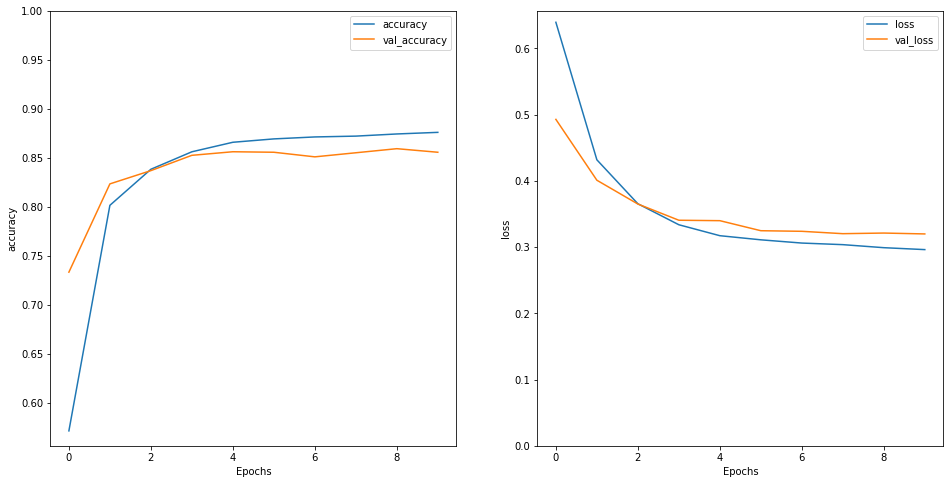

In [28]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [29]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

In [30]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 633s 2s/step - loss: 0.6796 - accuracy: 0.5154 - val_loss: 0.4307 - val_accuracy: 0.8115
Epoch 2/10
391/391 [==============================] - 5887s 15s/step - loss: 0.4054 - accuracy: 0.8152 - val_loss: 0.3440 - val_accuracy: 0.8432
Epoch 3/10
 19/391 [>.............................] - ETA: 8:04 - loss: 0.3446 - accuracy: 0.8460

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')